<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220728.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np 
import os
import re 
from datetime import datetime, date, time, timezone, timedelta 
import plotnine as gg 
from plotnine import ggplot, aes 

from functools import reduce
from collections import ChainMap, defaultdict, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 '.Rhistory',
 'rfm_test.csv',
 'retail_data_response.csv',
 'retail_data_transactions.csv',
 'items.csv',
 'item_categories.csv',
 'listings.csv',
 'ecommerce-data.csv',
 'sales_train.csv',
 'shops.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'test.csv',
 'online_retail_II.xlsx',
 'sample_submission.csv',
 'sample_data']

In [5]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 'Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [6]:
df.columns = df.iloc[0]
df.drop([0], axis = 0, inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [9]:
df = df[df.order_status == 'Approved']
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [10]:
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,date,month
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245,2017-02-25,2017-02-01
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701,2017-05-21,2017-05-01
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361,2017-10-16,2017-10-01
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145,2017-08-31,2017-08-01
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226,2017-10-01,2017-10-01


In [14]:
df = df[['customer_id', 'date', 'month', 'list_price']].rename(columns = {'customer_id':'id', 'list_price':'rev'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,1,2017-01-05,2017-01-01,360.4
1,1,2017-02-21,2017-02-01,71.49
2,1,2017-03-27,2017-03-01,688.63
3,1,2017-03-29,2017-03-01,1274.93
4,1,2017-04-06,2017-04-01,1577.53


In [15]:
list_pu = df.groupby(['id','month'])['rev'].sum().reset_index().sort_values(['id','month'],ascending = [1,1])
list_npu = df.groupby(['id']).first().reset_index()
list_mon = df['month'].sort_values().unique()

In [21]:
for mon in list_mon : 

  temp_npu = list_npu[list_npu['month'] == mon]
  temp_pu = list_pu[list_pu['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['month'])['id'].count().reset_index().rename(columns = {'id':'pu'})
  temp = temp.assign(npu_month = mon,
                     num =  temp['month'].rank(),
                     ratio = lambda x : round(x['pu']/x['pu'].max()*100,2)
                     )
  temp = temp.reindex(columns = ['npu_month', 'num', 'pu', 'ratio'])

  if mon == list_mon[0] :

    res = temp

  else :

    res = pd.concat([res, temp], axis = 0)

res['npu_month']= res['npu_month'].astype(str)
res = pd.melt(res, id_vars = ['npu_month', 'num'], var_name = 'type', value_name='value')
res.head()

,npu_month,num,type,value
0,2017-01-01,1.0,pu,1347.0
1,2017-01-01,2.0,pu,483.0
2,2017-01-01,3.0,pu,505.0
3,2017-01-01,4.0,pu,499.0
4,2017-01-01,5.0,pu,492.0


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


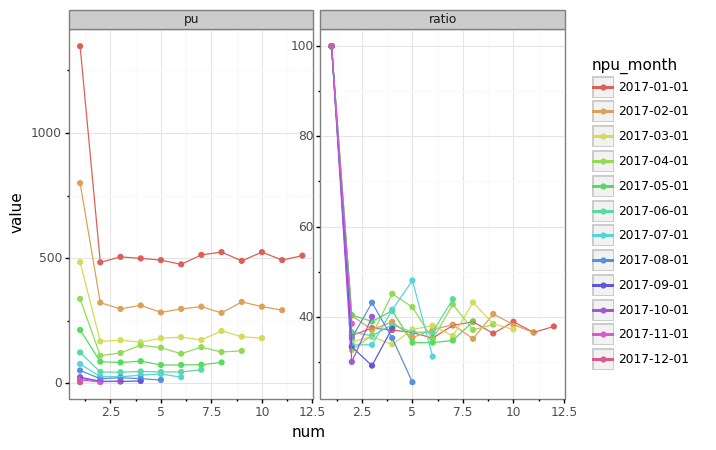

<ggplot: (8730059563861)>

In [22]:
(
    ggplot(res, aes('num', 'value', color = 'npu_month')) +
    gg.geom_point() +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

In [25]:
info_m = df.groupby(['id', 'month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').sort_values(['id','month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,1,1209.08
1,2,0.00
2,3,0.00
3,4,0.00
4,5,1812.75


In [26]:
info_f = df.groupby(['id', 'month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').sort_values(['id','month'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,1,3.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,1.0


In [48]:
date_max = (df['date'].dt.floor('d') + pd.offsets.MonthEnd(0)).max()
date_max

Timestamp('2017-12-31 00:00:00')

In [50]:
info_r = df.groupby(['id']).agg({'date': lambda x : (date_max - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,recency
0,1,8
1,2,129
2,3,103
3,4,196
4,5,17


In [51]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info.head()

,id,recency,freq,money
0,1,8,3.0,1209.08
1,2,129,0.0,0.00
2,3,103,0.0,0.00
3,4,196,0.0,0.00
4,5,17,1.0,1812.75


In [52]:
info = info.assign(r = pd.qcut(info.recency, 5, list('54321')),
                   f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')),
                   m = pd.qcut(info.money.rank(method = 'first'), 5, list('12345'))
                   )
info['fm'] = info['r'].astype(str) + info['m'].astype(str)
info.head()

,id,recency,freq,money,r,f,m,fm
0,1,8,3.0,1209.08,5,5,3,53
1,2,129,0.0,0.00,1,1,1,11
2,3,103,0.0,0.00,1,1,1,11
3,4,196,0.0,0.00,1,1,1,11
4,5,17,1.0,1812.75,4,2,4,44


# iterator

In [54]:
mat = [list('ABC'), list('DEF'), list('GHI')]
for r, rows in enumerate(mat) :
  for c, letter in enumerate(rows) :
    print(f'({r},{c}) : {letter}')

(0,0) : A
(0,1) : B
(0,2) : C
(1,0) : D
(1,1) : E
(1,2) : F
(2,0) : G
(2,1) : H
(2,2) : I


In [55]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'age': 73,
  'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M'},
 {'age': 29,
  'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F'},
 {'age': 51,
  'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M'},
 {'age': 32,
  'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F'},
 {'age': 42, 'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F'}]

In [69]:
for key in list(users[0].keys()) :

  if key == list(users[0].keys())[0] :
    
    res1 = eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')

  else :

    res1 = np.c_[res1, eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')]

res1


array([['gregorythomas@gmail.com', 'Brett Holland', 'M', '73'],
       ['hintoncynthia@hotmail.com', 'Madison Martinez', 'F', '29'],
       ['wwagner@gmail.com', 'Michael Jenkins', 'M', '51'],
       ['daniel79@gmail.com', 'Karen Rodriguez', 'F', '32'],
       ['ujackson@gmail.com', 'Amber Rhodes', 'F', '42']], dtype='<U25')

In [74]:
res2 = {key:eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users,[])') for key in list(users[0].keys())}
res2

{'age': [73, 29, 51, 32, 42],
 'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F']}

In [71]:
pd.DataFrame(res1, columns = users[0].keys())

,mail,name,sex,age
0,gregorythomas@gmail.com,Brett Holland,M,73
1,hintoncynthia@hotmail.com,Madison Martinez,F,29
2,wwagner@gmail.com,Michael Jenkins,M,51
3,daniel79@gmail.com,Karen Rodriguez,F,32
4,ujackson@gmail.com,Amber Rhodes,F,42


In [75]:
pd.DataFrame(res2)

,mail,name,sex,age
0,gregorythomas@gmail.com,Brett Holland,M,73
1,hintoncynthia@hotmail.com,Madison Martinez,F,29
2,wwagner@gmail.com,Michael Jenkins,M,51
3,daniel79@gmail.com,Karen Rodriguez,F,32
4,ujackson@gmail.com,Amber Rhodes,F,42


In [76]:
portfolio = [
    ('GOOG', 100, 490.1),
    ('IBM', 50, 91.1),
    ('CAT', 150, 83.44),
    ('IBM', 100, 45.23),
    ('GOOG', 75, 572.45),
    ('AA', 50, 23.15)
]
portfolio

[('GOOG', 100, 490.1),
 ('IBM', 50, 91.1),
 ('CAT', 150, 83.44),
 ('IBM', 100, 45.23),
 ('GOOG', 75, 572.45),
 ('AA', 50, 23.15)]

In [77]:
a, b = Counter(), defaultdict(list)

for com, share, price in portfolio :

  a[com] += share 
  b[com].append((share, price))

print(a)
print(b)

Counter({'GOOG': 175, 'IBM': 150, 'CAT': 150, 'AA': 50})
defaultdict(<class 'list'>, {'GOOG': [(100, 490.1), (75, 572.45)], 'IBM': [(50, 91.1), (100, 45.23)], 'CAT': [(150, 83.44)], 'AA': [(50, 23.15)]})
